## Import Libraries

In [23]:
# importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, train_test_split,  GridSearchCV, validation_curve
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

# classification algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

print('libraries imported!')

libraries imported!


## The Data

In [24]:
# importing dataset

column_names = ['age', 'blood pressure', 'specific gravity', 'albumin', 'sugar', 'red blood cells', 'pus cell', 'pus cell clumps', 'bacteria', 'blood glucose random', 'blood urea', 'serum creatinine', 'sodium', 'potassium', 'hemoglobin', 'packed cell volume', 'white blood cell count', 'red blood cell count', 'hypertension', 'diabetes mellitus', 'coronary artery disease', 'appetite', 'pedal edema', 'anemia', 'class']

df = pd.read_csv('Dataset/kidney_disease.csv', index_col='id')
df.columns = column_names
df.head()

,age,blood pressure,specific gravity,albumin,sugar,red blood cells,pus cell,pus cell clumps,bacteria,blood glucose random,...,packed cell volume,white blood cell count,red blood cell count,hypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,class
id,,,,,,,,,,,,,,,,,,,,,
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd


## Data Preparation

### Data Cleaning

In [25]:
# removing extra whitespaces
df = df.applymap(lambda column:column.strip() if type(column) == str else column)

# correcting physically impossible values, other typos, incorrect capitalisation
for column in df.columns:
    if(df[column].dtypes != 'float64'):
        df[column] = df[column].replace('(\t)*(\?)*', '', regex = True)
        
# correcting data types of columns
df['packed cell volume'] = pd.to_numeric(df['packed cell volume'])
df['red blood cell count'] = pd.to_numeric(df['red blood cell count'])
df['white blood cell count'] = pd.to_numeric(df['white blood cell count'])

### Data Transformation

In [26]:
# changing the target variable - 'class' to 1 if 'ckd' and 0 if 'notckd'
df['class'] = df['class'].apply(lambda value: 1 if value == 'ckd' else 0)

# bin the 'age' column
df['age'] = pd.cut(df['age'], bins=[-1, 18, 35, 50, 100], labels = ['0-18 years', '19-35 years', '36-50 years', '50+ years'])

# changing the nominal fields to numerical fields to feed them to the machine learning algorithms later
nominal_cols = df.select_dtypes(include=['object']).columns
yes_no_dict = {'yes':1, 'no':0}

numerical_vals = {
        'pus cell': {
        'normal': 0, 
        'abnormal': 1
    },
    'pus cell clumps': {
        'notpresent': 0,
        'present': 1
    },
    'bacteria': {
        'notpresent': 0,
        'present': 1
    },
    'hypertension': yes_no_dict,
    'diabetes mellitus': yes_no_dict,
    'coronary artery disease': yes_no_dict,
    'appetite': {
        'good': 1,
        'poor': 0
    },
    'pedal edema': yes_no_dict,
    'anemia': yes_no_dict,
    'age': {
        '0-18 years': 0,
        '19-35 years': 1,
        '36-50 years': 2,
        '50+ years': 3,
    }
}

# categorical values are replaced by their corresponding numerical ones
df = df.replace(numerical_vals)

df.head()

,age,blood pressure,specific gravity,albumin,sugar,red blood cells,pus cell,pus cell clumps,bacteria,blood glucose random,...,packed cell volume,white blood cell count,red blood cell count,hypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,class
id,,,,,,,,,,,,,,,,,,,,,
0,2.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,...,44.0,7800.0,5.2,1.0,1.0,0.0,1.0,0.0,0.0,1
1,0.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,...,38.0,6000.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1
2,3.0,80.0,1.010,2.0,3.0,normal,0.0,0.0,0.0,423.0,...,31.0,7500.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1
3,2.0,70.0,1.005,4.0,0.0,normal,1.0,1.0,0.0,117.0,...,32.0,6700.0,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1
4,3.0,80.0,1.010,2.0,0.0,normal,0.0,0.0,0.0,106.0,...,35.0,7300.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,1


### Feature Selection

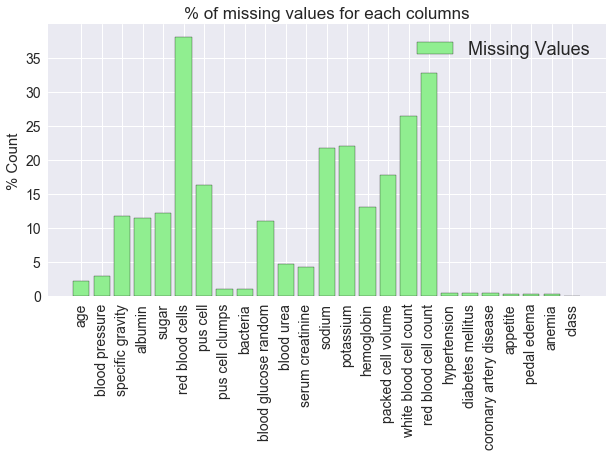

In [27]:
# visualising missing values for each columns

nan_count = np.array([])

for column in df.columns:
    nan_count = np.append(nan_count, df[column].isnull().sum())

fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.bar(column_names, pd.Series((nan_count/400)*100),label= 'Missing Values', color='lightgreen', edgecolor='black')
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='both', labelsize=14)
ax.set_title("% of missing values for each columns", fontsize=17)
ax.set_ylabel("% Count", fontsize=15)

plt.legend(prop= {'size':18})
plt.show()

In [28]:
# applying different feature selection techniques

# Missing Values Ratio - Filter Strategy (to filter some fields with higher % of missing values)
# dropping columns - 'rbc', 'wc' and 'rc' as they contain 38%, 26.5% and 32.75% missing values respectively i.e. > 25%
nan_count = (df.isnull().sum() / df.shape[0])*100
missing_value_threshold = 25

to_remove_columns = nan_count.where(nan_count > missing_value_threshold).dropna().index
# dropping columns
df.drop(to_remove_columns, axis=1, inplace=True)
print('columns dropped: ', to_remove_columns.values)

columns dropped:  ['red blood cells' 'white blood cell count' 'red blood cell count']


In [29]:
# replace missing values - Imputation

# columns to impute with less than 25% missing values in total
to_replace_mean = ['blood pressure', 'packed cell volume', 'potassium', 'sodium']
to_replace_mode = ['age', 'specific gravity', 'albumin', 'sugar', 'pus cell', 'pus cell clumps', 'bacteria', 'hypertension', 
                   'diabetes mellitus', 'coronary artery disease', 'appetite', 'pedal edema', 'anemia']
te_replace_median = ['blood glucose random', 'blood urea', 'serum creatinine', 'hemoglobin']

for column in to_replace_mean:
    df[column].fillna(round(df[column].mean(), 1), inplace = True)
for column in te_replace_median:
    df[column].fillna(df[column].median(), inplace = True)
for column in to_replace_mode:
    df[column].fillna(df[column].mode().iloc[0], inplace = True)

print('All remaining column values imputed!')

All remaining column values imputed!


In [30]:
# Low Variance Filter - Filter Strategy (to filter some fields with lower variance than some threshold value)

# first standardizing/normalising the data, so that all values are in range [0, 1]
min_max_scaler = MinMaxScaler()
num_cols = df.select_dtypes(include='number').columns
# normalised dataset with only numeric columns
df_standard = pd.DataFrame(min_max_scaler.fit_transform(df[num_cols]), columns=num_cols)

# variance feature selector
var_threshold=0.01
sel = VarianceThreshold(threshold=var_threshold)
sel.fit_transform(df_standard)
to_remove_num_columns = df_standard.loc[:, ~sel.get_support()].columns
df.drop(to_remove_num_columns, axis=1, inplace=True)

print('Numerical columns dropped: ', to_remove_num_columns.values)

# get categorical features
nominal_cols = set(nominal_cols).intersection(df.columns)

# filter nominal features that have either one or zero in more than 90% of total samples
prob = 0.9
# calculating variance for binomial random features
nom_threshold = prob*(1-prob)
sel = VarianceThreshold(threshold=nom_threshold)

sel.fit_transform(df[nominal_cols])
to_remove_nom_columns = df[nominal_cols].loc[:, ~sel.get_support()].columns
df.drop(to_remove_nom_columns, axis=1, inplace=True)

print('Nominal columns dropped: ', to_remove_nom_columns.values)

Numerical columns dropped:  ['serum creatinine' 'sodium' 'potassium']
Nominal columns dropped:  ['coronary artery disease' 'bacteria']


columns dropped:  ['sugar', 'blood pressure', 'age']


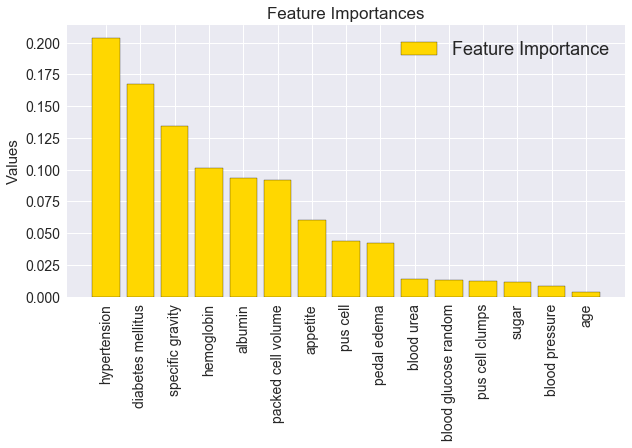

In [31]:
# Wrapper Strategy (to remove low scoring features corresponding to target feature using feature importances)

# input data and target attribute
X = df.iloc[:,0:15]
y = df.iloc[:,-1]

# feature selection using tree-based model - ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=2000, max_depth=3)
model.fit(X, y)

feature_importances = [(df.columns[i], round(value, 5)) for i, value in enumerate(model.feature_importances_)]
# sorting feature importance based on importance values
feature_importances.sort(key = lambda x: x[1], reverse=True)

# removing bottom three features - 'sugar', 'blood pressure' and 'age'
to_remove_columns = [col for col, value in feature_importances[-3:]]
df.drop(to_remove_columns, axis=1, inplace=True)

print('columns dropped: ', to_remove_columns)

# plotting feature importances for each fields
fig, ax = plt.subplots(1,1,figsize = (10,5))
column_names = [col for col, value in feature_importances]
data = [value for col, value in feature_importances]

ax.bar(column_names, data,label= 'Feature Importance', color='gold', edgecolor='black')
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='both', labelsize=14)
ax.set_title("Feature Importances", fontsize=17)
ax.set_ylabel("Values", fontsize=15)

plt.legend(prop= {'size':18})
plt.show()

Optimal number of features selected from:  7


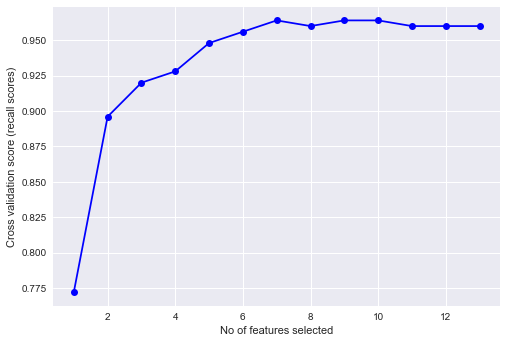

Features selected:  Index(['specific gravity', 'albumin', 'hemoglobin', 'packed cell volume',
       'hypertension', 'diabetes mellitus', 'appetite'],
      dtype='object')

columns dropped:  ['pus cell' 'pus cell clumps' 'blood glucose random' 'blood urea'
 'pedal edema' 'anemia']


In [32]:
# Backward Feature Elimination - Embedded Strategy

X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

# accuracy 'recall'
model = ExtraTreesClassifier(n_estimators=500, max_depth=3)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5),
              scoring='recall')
rfecv.fit(X, y)

print('Optimal number of features selected from: ', rfecv.n_features_)

# plotting cross-validation scores vs no. of features
plt.style.use('seaborn')
plt.figure()
plt.xlabel('No of features selected')
plt.ylabel('Cross validation score (recall scores)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, 'bo-')
plt.show()

print('Features selected: ', df.columns[:-1][rfecv.support_])

to_remove_columns = df.columns[~np.append(rfecv.support_, True)]
df.drop(to_remove_columns, axis=1, inplace=True)

print('\ncolumns dropped: ', to_remove_columns.values)

In [33]:
df.head()

,specific gravity,albumin,hemoglobin,packed cell volume,hypertension,diabetes mellitus,appetite,class
id,,,,,,,,
0,1.020,1.0,15.4,44.0,1.0,1.0,1.0,1
1,1.020,4.0,11.3,38.0,0.0,0.0,1.0,1
2,1.010,2.0,9.6,31.0,0.0,1.0,0.0,1
3,1.005,4.0,11.2,32.0,1.0,0.0,0.0,1
4,1.010,2.0,11.6,35.0,0.0,0.0,1.0,1


### Classification

In [34]:
# splitting the dataset into training (model training) and testing sets (model evaluation)

X, y = df.iloc[:, 0:-1], df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

# resetting index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

print('Training dataset size: {}'.format(X_train.shape))
print('Testing dataset size: {}\n'.format(X_test.shape))

print('Classification labels proportion in training set:')
y_train.value_counts()

Training dataset size: (268, 7)
Testing dataset size: (132, 7)

Classification labels proportion in training set:


1    168
0    100
Name: class, dtype: int64

In [35]:
# standardizing/normalising the training and testing dataset
# using z-scores for feature scaling
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

X_train_scaled.head()

,specific gravity,albumin,hemoglobin,packed cell volume,hypertension,diabetes mellitus,appetite
0,-0.519844,0.078971,-0.917541,-0.847233,1.360538,1.506085,-2.088061
1,-0.519844,-0.676897,0.045850,0.003543,-0.735003,1.506085,-2.088061
2,1.375641,-0.676897,0.209445,0.755677,-0.735003,-0.663973,0.478913
3,-0.519844,2.346578,-0.190454,-0.230729,1.360538,-0.663973,0.478913
4,-0.519844,1.590709,-0.117745,0.139173,1.360538,1.506085,0.478913


In [36]:
# function to plot confusion matrix

def plot_confusion_matrix(true, pred, model_name):
    cm = confusion_matrix(true, pred)
    
    # plotting matrix using heatmap
    fig,ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cm,annot=True, linecolor="black", fmt=".0f", ax=ax, cmap=plt.cm.Blues)
    plt.xlabel("Predicted value")
    plt.ylabel("Truth value")
    plt.title(model_name)
    
    plt.show()

Classification algorithms...


RandomForestClassifier--------------------------------
              precision    recall  f1-score   support

  notckd (0)       1.00      0.94      0.97        50
     ckd (1)       0.96      1.00      0.98        82

    accuracy                           0.98       132
   macro avg       0.98      0.97      0.98       132
weighted avg       0.98      0.98      0.98       132
 

Confusion matrix:


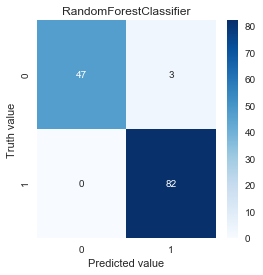

SVC---------------------------------------------------
              precision    recall  f1-score   support

  notckd (0)       0.94      0.90      0.92        50
     ckd (1)       0.94      0.96      0.95        82

    accuracy                           0.94       132
   macro avg       0.94      0.93      0.94       132
weighted avg       0.94      0.94      0.94       132
 

Confusion matrix:


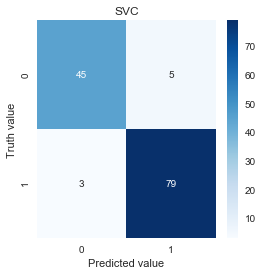

LogisticRegression------------------------------------
              precision    recall  f1-score   support

  notckd (0)       1.00      0.94      0.97        50
     ckd (1)       0.96      1.00      0.98        82

    accuracy                           0.98       132
   macro avg       0.98      0.97      0.98       132
weighted avg       0.98      0.98      0.98       132
 

Confusion matrix:


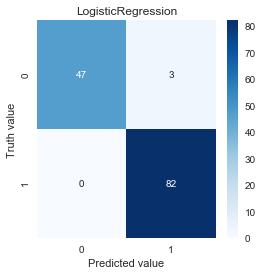

GaussianNB--------------------------------------------
              precision    recall  f1-score   support

  notckd (0)       0.89      1.00      0.94        50
     ckd (1)       1.00      0.93      0.96        82

    accuracy                           0.95       132
   macro avg       0.95      0.96      0.95       132
weighted avg       0.96      0.95      0.95       132
 

Confusion matrix:


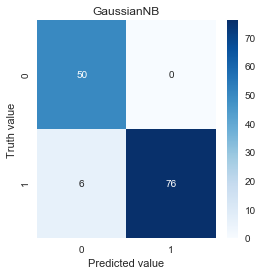

KNeighborsClassifier----------------------------------
              precision    recall  f1-score   support

  notckd (0)       0.92      0.94      0.93        50
     ckd (1)       0.96      0.95      0.96        82

    accuracy                           0.95       132
   macro avg       0.94      0.95      0.94       132
weighted avg       0.95      0.95      0.95       132
 

Confusion matrix:


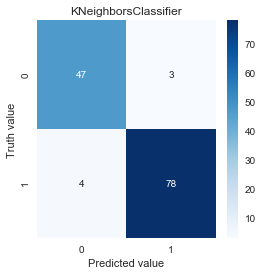

,Classification model,F1 score,Test mean accuracy
0,RandomForestClassifier,0.982036,0.977273
2,LogisticRegression,0.982036,0.977273
3,GaussianNB,0.962025,0.954545
4,KNeighborsClassifier,0.957055,0.946970
1,SVC,0.951807,0.939394


In [37]:
# script for training and testing different classification algorithms with default params

# classification algorithms
rf = RandomForestClassifier()
svm = SVC()
lr = LogisticRegression(max_iter=1000)
nb = GaussianNB()
knn = KNeighborsClassifier()

# evaluation results
scores = []
# algorithms to use
classification_algorithms = [rf, svm, lr, nb, knn]
# use scaled input dataset or not for algorithms' training
use_scaled_data = [False, False, False, False, False]

print('Classification algorithms...\n\n')

for model, use_norm in zip(classification_algorithms, use_scaled_data):
    # training and testing set
    X = (X_train_scaled if use_norm else X_train)
    X_test_ = (X_test_scaled if use_norm else X_test)
    
    # model fitting and predictions on test set
    model.fit(X, y_train)
    pred = model.predict(X_test_)
    
    # printing classification report, confusion matrix
    print('{}'.format(model.__class__.__name__.ljust(54, '-')))
    print(classification_report(y_test, pred, target_names=['notckd (0)', 'ckd (1)']), '\n')
    
    # confusion matrix
    print('Confusion matrix:')
    plot_confusion_matrix(y_test, pred, model.__class__.__name__)
    
    # model evaluation using recall score and mean accuracy on test set
    score_f1 = f1_score(y_test, pred)
    score = model.score(X_test, y_test)
    score = {
        'Classification model': model.__class__.__name__,
        'F1 score': score_f1,
        'Test mean accuracy': score
    }
    
    # append 'accuracy score' to 'scores'
    scores.append(score)

mean_accuracy_scores = pd.DataFrame(scores).sort_values(by='Test mean accuracy', ascending=False)
mean_accuracy_scores

### Selecting Random Forest Classifier parameters

Optimal no. of trees for RF:  25


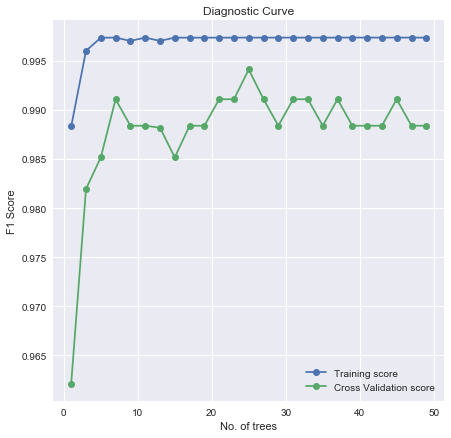

In [38]:
# plotting a diagnostic line plot to determine the optimal value of 'n_estimators' parameter in RandomForestClassifier model
# as model's performance is highly sensitive to it

# no. of trees to form is in range bewteen 1 and 50 (step size = 2)
no_of_trees = range(1,51,2)
# applying 10-fold cross-valation to evaluate CV f1 score
# returning training and test f1 scores
train_scores, test_scores = validation_curve(RandomForestClassifier(), X_train, y_train,
                                             param_range=no_of_trees,
                                             param_name='n_estimators',
                                             cv=10,
                                             n_jobs=-1,
                                             scoring='f1')

# plotting diagnostic plot
fig, ax = plt.subplots(figsize=(7,7))
avg_train_scores = np.mean(train_scores, axis=1)
avg_test_scores = np.mean(test_scores, axis=1)

ax.plot(no_of_trees, avg_train_scores, '-o', label='Training score')
ax.plot(no_of_trees, avg_test_scores, '-o', label='Cross Validation score')
# labelling
ax.set_xlabel('No. of trees')
ax.set_ylabel('F1 Score')
ax.set_title('Diagnostic Curve')
_ = ax.legend()

n_estimators = no_of_trees[np.argmax(avg_test_scores)]
print('Optimal no. of trees for RF: ', n_estimators)

In [39]:
# hyper-parameter tuning of RFC model with GridSearch

# parameter 'n_estimators' range is estimated from above diagnostic graph
tuned_params = [{'n_estimators':[n_estimators,7,9,11,23], 'max_depth':[2,3,4,5,6,None],
                 'min_samples_split':[2,3,4],'random_state':[42]}]

# using 10-fold cross validation
clf = GridSearchCV(RandomForestClassifier(), tuned_params, scoring='f1', cv=10, return_train_score=False)
clf.fit(X_train, y_train)
grid_results = pd.DataFrame(clf.cv_results_)

# printing results from grid search CV
print('Best params set: ', clf.best_params_)
print('Best score on cross-validation set: ', clf.best_score_)

results = grid_results[['params', 'mean_test_score', 'rank_test_score']]
# printing sorted results
results.sort_values(by='rank_test_score')

Best params set:  {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 25, 'random_state': 42}
Best score on cross-validation set:  0.9944444444444445


,params,mean_test_score,rank_test_score
44,"{'max_depth': 4, 'min_samples_split': 4, 'n_es...",0.994444,1
19,"{'max_depth': 3, 'min_samples_split': 2, 'n_es...",0.994444,1
15,"{'max_depth': 3, 'min_samples_split': 2, 'n_es...",0.994444,1
43,"{'max_depth': 4, 'min_samples_split': 4, 'n_es...",0.994444,1
33,"{'max_depth': 4, 'min_samples_split': 2, 'n_es...",0.994444,1
...,...,...,...
21,"{'max_depth': 3, 'min_samples_split': 3, 'n_es...",0.984416,85
26,"{'max_depth': 3, 'min_samples_split': 4, 'n_es...",0.984416,85
11,"{'max_depth': 2, 'min_samples_split': 4, 'n_es...",0.975182,88
1,"{'max_depth': 2, 'min_samples_split': 2, 'n_es...",0.975182,88


Classification report:
              precision    recall  f1-score   support

  notckd (0)       1.00      0.94      0.97        50
     ckd (1)       0.96      1.00      0.98        82

    accuracy                           0.98       132
   macro avg       0.98      0.97      0.98       132
weighted avg       0.98      0.98      0.98       132
 

Confusion matrix:


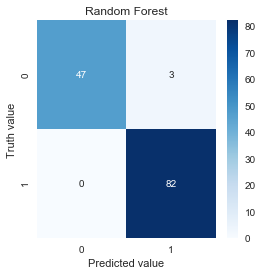

F1 score on test set: 0.98204
Average accuracy on test set: 0.97727


In [40]:
# predicting labels on test set
pred = clf.predict(X_test)

# printing classification report, confusion matrix
print('Classification report:')
print(classification_report(y_test, pred, target_names=['notckd (0)', 'ckd (1)']), '\n')

# confusion matrix
print('Confusion matrix:')
plot_confusion_matrix(y_test, pred, 'Random Forest')
print('F1 score on test set: {:.5f}'.format(f1_score(y_test, pred)))
print('Average accuracy on test set: {:.5f}'.format(accuracy_score(y_test, pred)))

### Selecting Logistic Regression Classifier parameters

Optimal value of C for Logistic Regression model:  100000.0


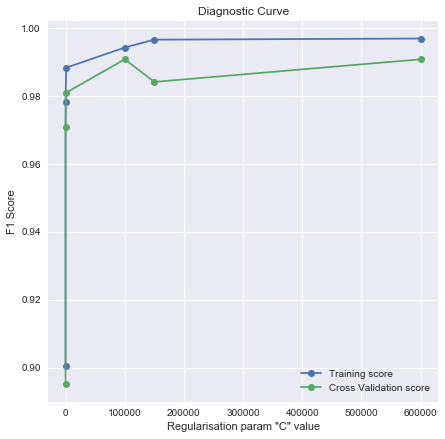

In [41]:
# plotting a diagnostic line plot to determine the optimal value of 'C' (regularisation parameter) in Logistic Regression model
# as model's performance is highly sensitive to it

# 'C' - regularisation parameter is in range between 0.001 and (6x10^5)
c_range = [0.001, 1, 1000, 1e5, 1.5e5, 6e5]
# applying 10-fold cross-valation to evaluate CV f1 score
# returning training and test f1 scores
train_scores, test_scores = validation_curve(LogisticRegression(), X_train, y_train,
                                             param_range=c_range,
                                             param_name='C',
                                             cv=10,
                                             n_jobs=-1,
                                             scoring='f1')

# plotting diagnostic plot
fig, ax = plt.subplots(figsize=(7,7))
avg_train_scores = np.mean(train_scores, axis=1)
avg_test_scores = np.mean(test_scores, axis=1)

ax.plot(c_range, avg_train_scores, '-o', label='Training score')
ax.plot(c_range, avg_test_scores, '-o', label='Cross Validation score')
# labelling
ax.set_xlabel('Regularisation param "C" value')
ax.set_ylabel('F1 Score')
ax.set_title('Diagnostic Curve')
_ = ax.legend()

optimal_c = c_range[np.argmax(avg_test_scores)]
print('Optimal value of C for Logistic Regression model: ', optimal_c)

              precision    recall  f1-score   support

  notckd (0)       1.00      1.00      1.00        50
     ckd (1)       1.00      1.00      1.00        82

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132
 

Confusion matrix:


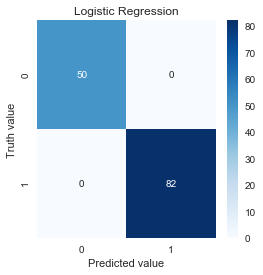

F1 score on test set: 1.00000
Average accuracy on test set: 1.00000


In [42]:
# Logistic Regression model fitting and testing with optimal params

# model fitting using optimal value of C
clf = LogisticRegression(C=optimal_c, max_iter=1000)
clf.fit(X_train, y_train)

# predicting labels on test set
pred = clf.predict(X_test)

# printing classification report, confusion matrix
print(classification_report(y_test, pred, target_names=['notckd (0)', 'ckd (1)']), '\n')

# confusion matrix
print('Confusion matrix:')
plot_confusion_matrix(y_test, pred, 'Logistic Regression')
print('F1 score on test set: {:.5f}'.format(f1_score(y_test, pred)))
print('Average accuracy on test set: {:.5f}'.format(accuracy_score(y_test, pred)))